In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
proto = './models/colorization_deploy_v2.prototxt'
weights = './models/colorization_release_v2.caffemodel'

#load cluster centers
pts_in_hull = np.load('./models/pts_in_hull.npy')
pts_in_hull = pts_in_hull.transpose().reshape(2,313,1,1).astype(np.float32)

#load model
net = cv2.dnn.readNetFromCaffe(proto,weights)

#populate cluster centers as 1x1 convolution kernel
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull]
#fill 2.606 to conv8_313_rh manually
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full((1,313),2.606,np.float32)]

# Preprocessing

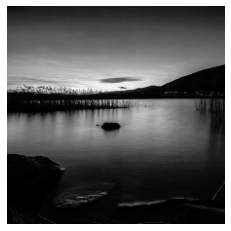

In [3]:
img_path = 'img/sample_26.jpg'
img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
img_input = img.copy()

#convert BGR to RGB
img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

img_rgb = img.copy()
#normalize input
img_rgb = (img_rgb / 255.).astype(np.float32)
#convert RGB to LAB
img_lab = cv2.cvtColor(img_rgb,cv2.COLOR_RGB2Lab)
#only L channel used
img_l = img_lab[:,:,0]

#adjust image
input_img = cv2.resize(img_l,(224,224))
input_img -= 50 #subtract 50 for mean centering

plt.axis('off')
plt.imshow(input_img, cmap='gray')

# Prediction

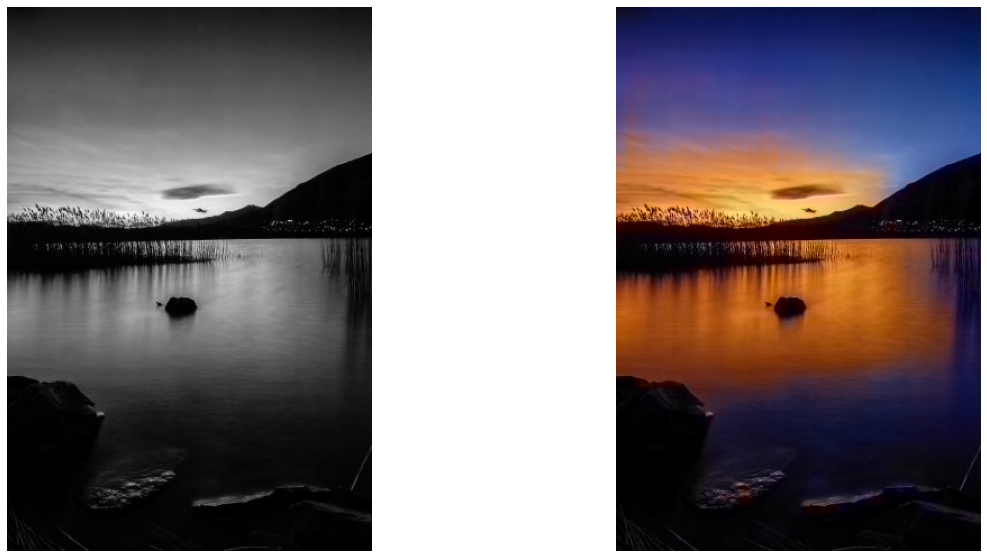

In [4]:
net.setInput(cv2.dnn.blobFromImage(input_img))
pred = net.forward()[0,:,:,:].transpose((1,2,0))

#resize to original shape
pred_resize = cv2.resize(pred,(img.shape[1],img.shape[0]))

#concatenate with original image L
pred_lab = np.concatenate([img_l[:,:,np.newaxis],pred_resize],axis=2)

#convert LAB to RGB
pred_rgb = cv2.cvtColor(pred_lab,cv2.COLOR_Lab2RGB)
pred_rgb = np.clip(pred_rgb,0,1)*255
pred_rgb = pred_rgb.astype(np.uint8)

#plot prediction result
fig = plt.figure(figsize=(20,10))
fig.add_subplot(1,2,1).axis('off')
plt.imshow(img_l,cmap = 'gray')
fig.add_subplot(1,2,2).axis('off')
plt.imshow(pred_rgb)

In [5]:
#save result image
filename, ext = os.path.splitext(img_path)
input_filename = '%s_input%s'%(filename,ext)
output_filename = '%s_output%s'%(filename,ext)

pred_rgb_output = cv2.cvtColor(pred_rgb,cv2.COLOR_RGB2BGR)

cv2.imwrite(input_filename,img_input)
cv2.imwrite(output_filename,np.concatenate([img,pred_rgb_output],axis=1))

True